In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
# os.chdir("drive/20190424") 
os.chdir("drive/BME_lung") 
! ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
 drive				        ResNet_runloss.ipynb（副本）
'GCP Credits Request Link - RSNA.txt'   stage_2_detailed_class_info.csv
 multi0605_layer1622_best_model.h5      stage_2_sample_submission.csv
 multi_layer1623_best_model.h5	        stage_2_test_images
 multi_layer_best_model.h5	        stage_2_train_images
 multi_layer_best_modelResNetLoss.h5    stage_2_train_labels.csv
 ResNet_loss_model.png		        VGG.png


In [0]:
! pip install pydicom

In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [0]:
folder = '../BME_lung/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 550
train_filenames = filenames[n_valid_samples:]  
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))  # 4700
print('n valid samples', len(valid_filenames))  # 550
n_train_samples = len(filenames) - n_valid_samples

n train samples 4700
n valid samples 550


In [0]:
pneumonia_locations = {}
# load table
with open(os.path.join('../BME_lung/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    #i=0
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            #i = i+1
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
                
            else:
                pneumonia_locations[filename] = [location]
    #print(i)            

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False): # image_size=320 #0604
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        ## load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array #0604
        # img = pydicom.dcmread(os.path.join(self.folder, filename))
        # img.PixelRepresentation = 0
        ##print(img.dir())
        ##plt.imshow(img.pixel_array, cmap=plt.cm.bone)
        ##plt.show()
        ## create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        if self.augment and random.random() > 0.5:  # 0604
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        #if self.augment and random.random() > 0.5: # 0604
        #    img = np.fliplr(img)
        #    msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    # x = keras.layers.BatchNormalization(momentum=0.9)(x)
    outputs = keras.layers.UpSampling2D(2**(depth))(x)
    # x = keras.layers.UpSampling2D(4)(x)
    # x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    # x = keras.layers.BatchNormalization(momentum=0.9)(x)
    # outputs = keras.layers.UpSampling2D(2)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_loss,
              metrics=['accuracy', mean_iou])
model.load_weights('multi_layer_best_modelResNetLoss.h5')
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25 #64
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = [tf.keras.callbacks.LearningRateScheduler(cosine_annealing),
                ModelCheckpoint('finall2_best_model.h5',monitor='val_acc',save_best_only=True)]


folder = '../BME_lung/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 256, 256, 32) 288         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_114 (Bat (None, 256, 256, 32) 128         conv2d_118[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_111 (LeakyReLU)     (None, 256, 256, 32) 0           batch_normalization_v1_114[0][0] 
__________________________________________________________________________________________________
conv2d_119

In [0]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=learning_rate, epochs=8 )

Epoch 1/8
146/146 [==============================] - 1978s 14s/step - loss: 0.7903 - acc: 0.9351 - mean_iou: 0.4803 - val_loss: 0.8009 - val_acc: 0.9168 - val_mean_iou: 0.4004
Epoch 2/8
146/146 [==============================] - 1832s 13s/step - loss: 0.7726 - acc: 0.9416 - mean_iou: 0.5283 - val_loss: 0.7716 - val_acc: 0.9534 - val_mean_iou: 0.5322
Epoch 3/8
 12/146 [=>............................] - ETA: 2:50 - loss: 0.7763 - acc: 0.9429 - mean_iou: 0.5076

In [0]:
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()

plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()


plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()

plt.show()

In [0]:
import pydot_ng
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
pydot_ng.find_graphviz()
plot_model(model, to_file='ResNet_loss_model.png',show_shapes=True )

In [0]:
for imgs, msks in valid_gen:
    #print(imgs[1].shape)
    #print(msks.shape)
    #print(imgs[1,:,:,0].shape)
    #plt.imshow(imgs[1,:,:,0],cmap='gray')
    #plt.show()
    #break
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,10))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    i=0
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        # i=i+1
        # if i==2:
        #   continue
        # if i==4:
        #   continue
        # if i==5:
        #   continue
        # if i==11:
        #   continue
        # if i==15:
        #   continue
        # if i==16:
        #   continue
        # if i==19:
        #   continue
        # if i==23:
        #   continue
        # if i==24:
        #   continue
        axarr[axidx].imshow(img[:,:,0],cmap='gray')
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [0]:
for imgs, msks in valid_gen:
    #print(imgs[1].shape)
    #print(msks.shape)
    #print(imgs[1,:,:,0].shape)
    #plt.imshow(imgs[1,:,:,0],cmap='gray')
    #plt.show()
    #break
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 5, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    i=0
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        i=i+1
        if i==2:
          continue
        if i==4:
          continue
        if i==5:
          continue
        if i==11:
          continue
        if i==15:
          continue
        if i==16:
          continue
        if i==19:
          continue
        if i==23:
          continue
        if i==24:
          continue
        axarr[axidx].imshow(img[:,:,0],cmap='gray')
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break


测试**测试**

In [0]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [0]:
# import matplotlib
# import tensorflow as tf
# from tensorflow import keras
# matplotlib.use('Agg')
# matplotlib.use('TkAgg')
# import os

# import numpy as np
# sudo apt-get install tk-dev
# import cv2
#加载模型h5文件

model_name = 'multi_layer_best_modelResNetLoss.h5'
model = keras.models.load_model(model_name,
                        custom_objects={'iou_loss': iou_loss,'mean_iou':mean_iou})

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization_v1[0][0]     
_____________________________________

In [0]:
test= generator(folder, valid_filenames, pneumonia_locations, batch_size=1, image_size=256, shuffle=True, predict=False)

In [0]:
I = pydicom.dcmread('stage_2_test_images/1ffb8eee-5a79-48a8-9f14-eada75c26c19.dcm').pixel_array
img = resize(I, (256, 256), mode='reflect')
img = np.expand_dims(img, -1)
img_4 = img.reshape(1,256,256,1)

imgs.shape: (1, 256, 256, 1)
preds.shape: (1, 256, 256, 1)


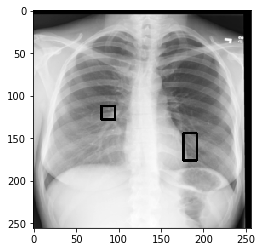

In [0]:
print("imgs.shape:",imgs.shape)
imgs = img_4
preds = model.predict(imgs)
print("preds.shape:",preds.shape)

img = imgs[0]
pred = preds[0]
comp = pred[:, :, 0] > 0.3

comp = measure.label(comp)
predictionString = ''
for region in measure.regionprops(comp):  
    y, x, y2, x2 = region.bbox
    height = y2 - y
    width = x2 - x
    cv2.rectangle(img[:,:,0],(x,y),(x2,y2),(0,255),2)
    
plt.imshow(img[:,:,0],cmap="gray")
plt.show()

imgs.shape: (1, 256, 256, 1)
preds.shape: (1, 256, 256, 1)
1
(256, 256, 1)
pred.shape (256, 256, 1)


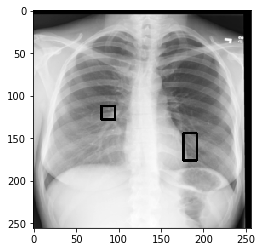

In [0]:

print("imgs.shape:",imgs.shape)
imgs = img_4
preds = model.predict(imgs)
print("preds.shape:",preds.shape)

for img, pred in zip(imgs, preds):
    comp = pred[:, :, 0] > 0.3
    
    comp = measure.label(comp)
    predictionString = ''
    for region in measure.regionprops(comp):  
        y, x, y2, x2 = region.bbox
        height = y2 - y
        width = x2 - x
        cv2.rectangle(img[:,:,0],(x,y),(x2,y2),(0,255),2)
        
    plt.imshow(img[:,:,0],cmap="gray")
plt.show()

imgs.shape: (256, 256, 1)
preds.shape: (1, 256, 256, 1)
1
(256, 256, 1)
pred.shape (256, 256, 1)
(256, 256, 1)
(256, 256, 1)


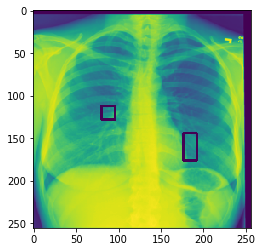

In [0]:
# from matplotlib import pyplot as plt
import cv2
for imgs in img_4:
    print("imgs.shape:",imgs.shape)
    imgs = img_4
    preds = model.predict(imgs)
    print("preds.shape:",preds.shape)
    
    # f, axarr = plt.subplots(2, 2, figsize=(20,15))
    # axarr = axarr.ravel()
    # axidx = 0
    # loop through batch
    i=0
    for img, pred in zip(imgs, preds):
        i=i+1
        print(i)
        print(img.shape)
        print("pred.shape",pred.shape)
       
        # eak
        # axarr[axidx].imshow(img[:,:,0],cmap='gray')
        # plt.imshow(img[:,:,0],cmap='gray')
        comp = pred[:, :, 0] > 0.3
        
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
            # plt.add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
            print(img[:,:].shape)
            cv2.rectangle(img[:,:,0],(x,y),(x2,y2),(0,255),2)
            
        plt.imshow(img[:,:,0])
    plt.show()
    
    break


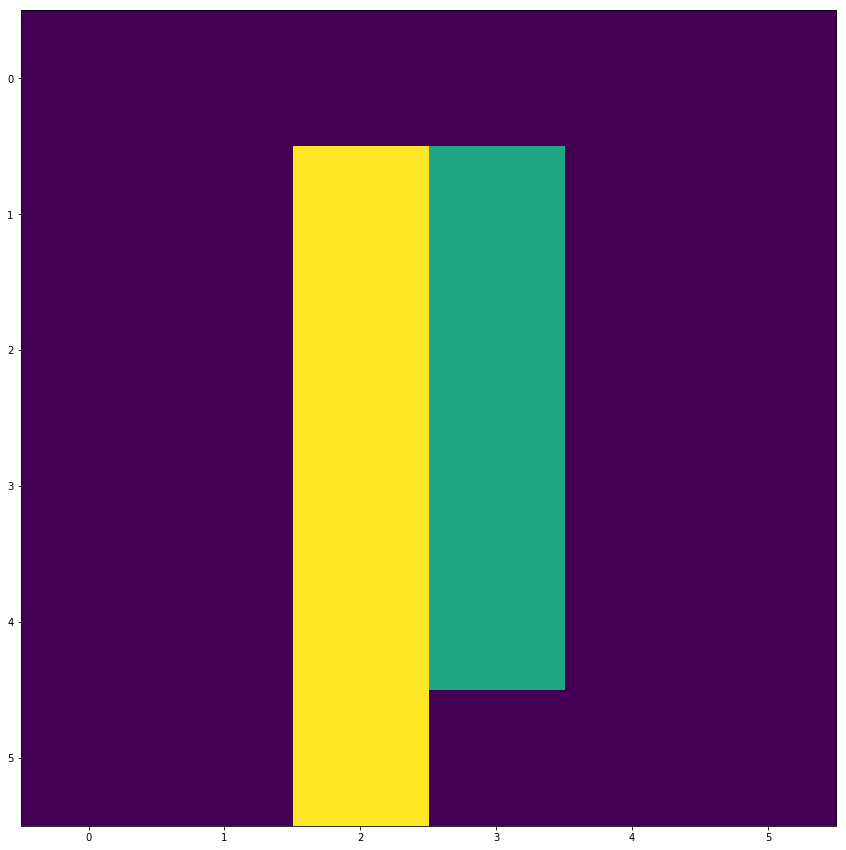

In [0]:
# import pylab
a=np.array([[0., 0., 0., 0., 0., 0.],
 [0., 0., 0.5, 0.3, 0., 0.],
 [0., 0., 0.5, 0.3, 0., 0.],
 [0., 0., 0.5, 0.3, 0., 0.],
 [0., 0., 0.5, 0.3, 0., 0.],
 [0., 0., 0.5, 0., 0., 0.]])
plt.figure(figsize=(15,15))
plt.imshow(a)
plt.show()
# pylab.show(a)